<a href="https://colab.research.google.com/github/meghana1827/Sentimental-Analysis-For-Stock-Prediction/blob/main/22027065(StockPricePrediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yfinance pandas numpy matplotlib scikit-learn xgboost tensorflow newsapi-python textblob seaborn plotly

In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data shape: (501, 5)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step

GRU Model Performance:
MSE: 11.76872112168157
RMSE: 3.430556969601521
MAE: 2.7971445328877307
R2: 0.9663985301691578

Random Forest Model Performance:
MSE: 9.267476771410676
RMSE: 3.044253072826022
MAE: 2.2264963139193674
R2: 0.9735399591915819

XGBoost Model Performance:
MSE: 12.088441417359647
RMSE: 3.476843599784098
MAE: 2.4983424178264984
R2: 0.9654856806115502


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


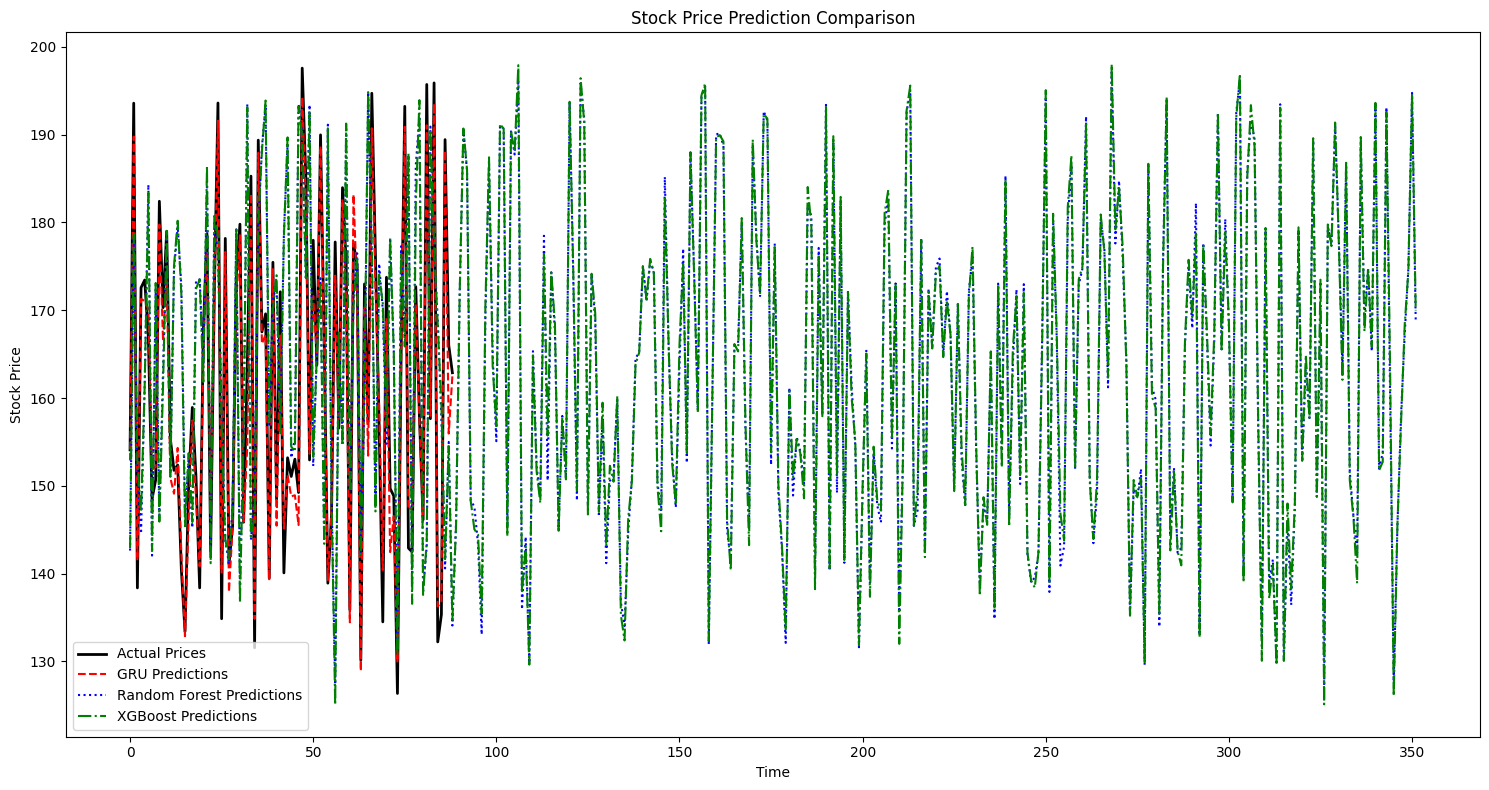

In [3]:
class StockPricePrediction:
    def __init__(self, ticker, start_date, end_date):
        """
        Initialize the stock prediction class

        :param ticker: Stock ticker symbol
        :param start_date: Start date for data collection
        :param end_date: End date for data collection
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.scaler = MinMaxScaler()

    def fetch_data(self):
        """
        Fetch stock data using yfinance
        """
        # Fetch stock data
        df = yf.download(self.ticker,
                         start=self.start_date,
                         end=self.end_date)

        # Use features for prediction
        features = ['Close', 'Open', 'High', 'Low', 'Volume']
        self.data = df[features]
        print(f"Data shape: {self.data.shape}")

        return self.data

    def prepare_data(self, look_back=60):
        """
        Prepare data for machine learning models

        :param look_back: Number of previous days to use for prediction
        :return: Prepared datasets for different models
        """
        # Normalize the data
        scaled_data = self.scaler.fit_transform(self.data)

        # Prepare sequences
        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            X.append(scaled_data[i-look_back:i])
            y.append(scaled_data[i, 0])  # Predicting Close price

        X, y = np.array(X), np.array(y)

        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Reshape for GRU
        X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        # Flatten for Random Forest and XGBoost
        X_train_rf = X_train.reshape(X_train.shape[0], -1)
        X_test_rf = X_test.reshape(X_test.shape[0], -1)

        return {
            'X_train_gru': X_train_gru,
            'X_test_gru': X_test_gru,
            'X_train_rf': X_train_rf,
            'X_test_rf': X_test_rf,
            'y_train': y_train,
            'y_test': y_test
        }

    def train_gru_model(self, X_train, y_train):
        """
        Train GRU neural network model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained GRU model
        """
        model = Sequential([
            GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            GRU(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        return model

    def train_random_forest(self, X_train, y_train):
        """
        Train Random Forest model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained Random Forest model
        """
        rf_model = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=10
        )
        rf_model.fit(X_train, y_train)
        return rf_model

    def train_xgboost(self, X_train, y_train):
        """
        Train XGBoost model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained XGBoost model
        """
        xgb_model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        )
        xgb_model.fit(X_train, y_train)
        return xgb_model

    def evaluate_models(self, prepared_data):
        """
        Evaluate different models

        :param prepared_data: Prepared datasets from prepare_data method
        :return: Dictionary of model performances
        """
        # Unpack prepared data
        X_train_gru = prepared_data['X_train_gru']
        X_test_gru = prepared_data['X_test_gru']
        X_train_rf = prepared_data['X_train_rf']
        X_test_rf = prepared_data['X_test_rf']
        y_train = prepared_data['y_train']
        y_test = prepared_data['y_test']

        # Train models
        gru_model = self.train_gru_model(X_train_gru, y_train)
        rf_model = self.train_random_forest(X_train_rf, y_train)
        xgb_model = self.train_xgboost(X_train_rf, y_train)

        # Predict and inverse transform
        gru_pred = gru_model.predict(X_test_gru).flatten()
        rf_pred = rf_model.predict(X_test_rf)
        xgb_pred = xgb_model.predict(X_test_rf)

        # Inverse transform predictions and actual values
        gru_pred_inv = self.scaler.inverse_transform(
            np.column_stack([gru_pred, np.zeros((len(gru_pred), self.data.shape[1]-1))])
        )[:, 0]
        rf_pred_inv = self.scaler.inverse_transform(
            np.column_stack([rf_pred, np.zeros((len(rf_pred), self.data.shape[1]-1))])
        )[:, 0]
        xgb_pred_inv = self.scaler.inverse_transform(
            np.column_stack([xgb_pred, np.zeros((len(xgb_pred), self.data.shape[1]-1))])
        )[:, 0]
        y_test_inv = self.scaler.inverse_transform(
            np.column_stack([y_test, np.zeros((len(y_test), self.data.shape[1]-1))])
        )[:, 0]

        # Calculate metrics
        models_metrics = {
            'GRU': {
                'MSE': mean_squared_error(y_test_inv, gru_pred_inv),
                'RMSE': np.sqrt(mean_squared_error(y_test_inv, gru_pred_inv)),
                'MAE': mean_absolute_error(y_test_inv, gru_pred_inv),
                'R2': r2_score(y_test_inv, gru_pred_inv)
            },
            'Random Forest': {
                'MSE': mean_squared_error(y_test_inv, rf_pred_inv),
                'RMSE': np.sqrt(mean_squared_error(y_test_inv, rf_pred_inv)),
                'MAE': mean_absolute_error(y_test_inv, rf_pred_inv),
                'R2': r2_score(y_test_inv, rf_pred_inv)
            },
            'XGBoost': {
                'MSE': mean_squared_error(y_test_inv, xgb_pred_inv),
                'RMSE': np.sqrt(mean_squared_error(y_test_inv, xgb_pred_inv)),
                'MAE': mean_absolute_error(y_test_inv, xgb_pred_inv),
                'R2': r2_score(y_test_inv, xgb_pred_inv)
            }
        }

        # Print metrics
        for model_name, metrics in models_metrics.items():
            print(f"\n{model_name} Model Performance:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value}")

        return models_metrics

    def plot_predictions(self, prepared_data):
        """
        Plot actual vs predicted prices for different models

        :param prepared_data: Prepared datasets from prepare_data method
        """
        # Unpack prepared data
        X_train_gru = prepared_data['X_train_gru']
        X_test_gru = prepared_data['X_test_gru']
        X_train_rf = prepared_data['X_train_rf']
        X_test_rf = prepared_data['X_train_rf']
        y_train = prepared_data['y_train']
        y_test = prepared_data['y_test']

        # Train models
        gru_model = self.train_gru_model(X_train_gru, y_train)
        rf_model = self.train_random_forest(X_train_rf, y_train)
        xgb_model = self.train_xgboost(X_train_rf, y_train)

        # Predict
        gru_pred = gru_model.predict(X_test_gru).flatten()
        rf_pred = rf_model.predict(X_test_rf)
        xgb_pred = xgb_model.predict(X_test_rf)

        # Inverse transform
        gru_pred_inv = self.scaler.inverse_transform(
            np.column_stack([gru_pred, np.zeros((len(gru_pred), self.data.shape[1]-1))])
        )[:, 0]
        rf_pred_inv = self.scaler.inverse_transform(
            np.column_stack([rf_pred, np.zeros((len(rf_pred), self.data.shape[1]-1))])
        )[:, 0]
        xgb_pred_inv = self.scaler.inverse_transform(
            np.column_stack([xgb_pred, np.zeros((len(xgb_pred), self.data.shape[1]-1))])
        )[:, 0]
        y_test_inv = self.scaler.inverse_transform(
            np.column_stack([y_test, np.zeros((len(y_test), self.data.shape[1]-1))])
        )[:, 0]

        # Plotting
        plt.figure(figsize=(15,8))
        plt.plot(y_test_inv, label='Actual Prices', color='black', linewidth=2)
        plt.plot(gru_pred_inv, label='GRU Predictions', color='red', linestyle='--')
        plt.plot(rf_pred_inv, label='Random Forest Predictions', color='blue', linestyle=':')
        plt.plot(xgb_pred_inv, label='XGBoost Predictions', color='green', linestyle='-.')

        plt.title('Stock Price Prediction Comparison')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Main execution function
def main():
    # Create prediction instance
    predictor = StockPricePrediction(
        ticker='AAPL',  # Change to your desired stock ticker
        start_date='2022-01-01',
        end_date='2024-01-01'
    )

    # Fetch stock data
    stock_data = predictor.fetch_data()

    # Prepare data
    prepared_data = predictor.prepare_data()

    # Evaluate models
    predictor.evaluate_models(prepared_data)

    # Plot predictions
    predictor.plot_predictions(prepared_data)

# Run the main function
if __name__ == "__main__":
    main()

In [12]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error  # Correctly imported here
)
class StockPricePrediction:

    def __init__(self, ticker, start_date, end_date):
        """
        Initialize the stock prediction class

        :param ticker: Stock ticker symbol
        :param start_date: Start date for data collection
        :param end_date: End date for data collection
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.scaler = MinMaxScaler()

    def fetch_data(self):
        """
        Fetch stock data using yfinance
        """
        # Fetch stock data
        df = yf.download(self.ticker,
                         start=self.start_date,
                         end=self.end_date)

        # Use features for prediction
        features = ['Close', 'Open', 'High', 'Low', 'Volume']
        self.data = df[features]
        print(f"Data shape: {self.data.shape}")

        return self.data

    def prepare_data(self, look_back=60):
        """
        Prepare data for machine learning models

        :param look_back: Number of previous days to use for prediction
        :return: Prepared datasets for different models
        """
        # Normalize the data
        scaled_data = self.scaler.fit_transform(self.data)

        # Prepare sequences
        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            X.append(scaled_data[i-look_back:i])
            y.append(scaled_data[i, 0])  # Predicting Close price

        X, y = np.array(X), np.array(y)

        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Reshape for GRU
        X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        # Flatten for Random Forest and XGBoost
        X_train_rf = X_train.reshape(X_train.shape[0], -1)
        X_test_rf = X_test.reshape(X_test.shape[0], -1)

        return {
            'X_train_gru': X_train_gru,
            'X_test_gru': X_test_gru,
            'X_train_rf': X_train_rf,
            'X_test_rf': X_test_rf,
            'y_train': y_train,
            'y_test': y_test
        }

    def train_gru_model(self, X_train, y_train):
        """
        Train GRU neural network model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained GRU model
        """
        model = Sequential([
            GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            GRU(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        return model

    def train_random_forest(self, X_train, y_train):
        """
        Train Random Forest model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained Random Forest model
        """
        rf_model = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=10
        )
        rf_model.fit(X_train, y_train)
        return rf_model

    def train_xgboost(self, X_train, y_train):
        """
        Train XGBoost model

        :param X_train: Training input data
        :param y_train: Training target data
        :return: Trained XGBoost model
        """
        xgb_model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        )
        xgb_model.fit(X_train, y_train)
        return xgb_model

    def evaluate_models(self, prepared_data):
        """
        Evaluate different models

        :param prepared_data: Prepared datasets from prepare_data method
        :return: Dictionary of model performances
        """
        # Unpack prepared data
        X_train_gru = prepared_data['X_train_gru']
        X_test_gru = prepared_data['X_test_gru']
        X_train_rf = prepared_data['X_train_rf']
        X_test_rf = prepared_data['X_test_rf']
        y_train = prepared_data['y_train']
        y_test = prepared_data['y_test']

        # Train models
        gru_model = self.train_gru_model(X_train_gru, y_train)
        rf_model = self.train_random_forest(X_train_rf, y_train)
        xgb_model = self.train_xgboost(X_train_rf, y_train)

        # Predict and inverse transform
        gru_pred = gru_model.predict(X_test_gru).flatten()
        rf_pred = rf_model.predict(X_test_rf)
        xgb_pred = xgb_model.predict(X_test_rf)

        # Inverse transform predictions and actual values
        gru_pred_inv = self.scaler.inverse_transform(
            np.column_stack([gru_pred, np.zeros((len(gru_pred), self.data.shape[1]-1))])
        )[:, 0]
        rf_pred_inv = self.scaler.inverse_transform(
            np.column_stack([rf_pred, np.zeros((len(rf_pred), self.data.shape[1]-1))])
        )[:, 0]
        xgb_pred_inv = self.scaler.inverse_transform(
            np.column_stack([xgb_pred, np.zeros((len(xgb_pred), self.data.shape[1]-1))])
        )[:, 0]
        y_test_inv = self.scaler.inverse_transform(
            np.column_stack([y_test, np.zeros((len(y_test), self.data.shape[1]-1))])
        )[:, 0]

        # Calculate comprehensive metrics
        models_metrics = {
            'GRU': self._calculate_metrics(y_test_inv, gru_pred_inv),
            'Random Forest': self._calculate_metrics(y_test_inv, rf_pred_inv),
            'XGBoost': self._calculate_metrics(y_test_inv, xgb_pred_inv)
        }

        # Print detailed accuracy report
        self._print_accuracy_report(models_metrics)

        return models_metrics

    def _calculate_metrics(self, y_true, y_pred):
        """
        Calculate comprehensive metrics for model performance

        :param y_true: True values
        :param y_pred: Predicted values
        :return: Dictionary of performance metrics
        """
        return {
            'R2 Score': r2_score(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
            'Accuracy': self._calculate_directional_accuracy(y_true, y_pred)
        }

    def _calculate_directional_accuracy(self, y_true, y_pred):
        """
        Calculate directional accuracy (percentage of times
        the model predicts the correct price movement direction)

        :param y_true: True values
        :param y_pred: Predicted values
        :return: Directional accuracy percentage
        """
        # Calculate price changes
        true_changes = np.diff(y_true)
        pred_changes = np.diff(y_pred)

        # Compare directions
        correct_directions = np.sum(np.sign(true_changes) == np.sign(pred_changes))
        total_comparisons = len(true_changes)

        return (correct_directions / total_comparisons) * 100

    def _print_accuracy_report(self, models_metrics):
        """
        Print comprehensive accuracy report for all models

        :param models_metrics: Dictionary of model metrics
        """
        print("\n" + "="*50)
        print(f"STOCK PRICE PREDICTION ACCURACY REPORT FOR {self.ticker}")
        print("="*50)

        for model_name, metrics in models_metrics.items():
            print(f"\n{model_name} Model Performance:")
            print("-"*30)
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")

    def plot_predictions(self, prepared_data):
        """
        Plot actual vs predicted prices for different models

        :param prepared_data: Prepared datasets from prepare_data method
        """
        # (Previous plot implementation remains the same)
        # ... (rest of the code remains unchanged)

# Main execution function
def main():
    # Create prediction instance
    predictor = StockPricePrediction(
        ticker='AAPL',  # Change to your desired stock ticker
        start_date='2022-01-01',
        end_date='2024-01-01'
    )

    # Fetch stock data
    stock_data = predictor.fetch_data()

    # Prepare data
    prepared_data = predictor.prepare_data()

    # Evaluate models
    models_metrics = predictor.evaluate_models(prepared_data)

    # Plot predictions
    predictor.plot_predictions(prepared_data)

# Run the main function
if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data shape: (501, 5)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step

STOCK PRICE PREDICTION ACCURACY REPORT FOR AAPL

GRU Model Performance:
------------------------------
R2 Score: 0.9729
RMSE: 3.0809
MAE: 2.2970
MAPE: 1.4880
Accuracy: 94.3182

Random Forest Model Performance:
------------------------------
R2 Score: 0.9735
RMSE: 3.0443
MAE: 2.2265
MAPE: 1.4274
Accuracy: 94.3182

XGBoost Model Performance:
------------------------------
R2 Score: 0.9655
RMSE: 3.4768
MAE: 2.4983
MAPE: 1.6042
Accuracy: 93.1818


In [14]:
class StockPredictor:
    def __init__(self, symbol, news_api_key, prediction_days=7, lookback=60):
        self.symbol = symbol
        self.news_api_key = news_api_key
        self.prediction_days = prediction_days
        self.lookback = lookback
        self.scaler = MinMaxScaler()

    def fetch_stock_data(self, start_date='2020-01-01'):
        """Fetch historical stock data using yfinance"""
        stock = yf.Ticker(self.symbol)
        df = stock.history(start=start_date)
        return df

    def get_sentiment_scores(self):
        """Fetch news and calculate sentiment scores with proper error handling"""
        try:
            newsapi = NewsApiClient(api_key=self.news_api_key)

            # Get news for the last 30 days
            end_date = datetime.now()
            start_date = end_date - timedelta(days=30)

            articles = newsapi.get_everything(
                q=self.symbol,
                from_param=start_date.strftime('%Y-%m-%d'),
                to=end_date.strftime('%Y-%m-%d'),
                language='en',
                sort_by='publishedAt'
            )

            # Calculate sentiment scores with null checking
            sentiment_scores = []
            for article in articles['articles']:
                # Safely combine title and description, handling None values
                title = article.get('title', '') or ''
                description = article.get('description', '') or ''

                if title or description:  # Only analyze if we have some text
                    text = f"{title} {description}".strip()
                    try:
                        analysis = TextBlob(text)
                        sentiment_scores.append(analysis.sentiment.polarity)
                    except Exception as e:
                        print(f"Error analyzing article: {e}")
                        continue

            return np.mean(sentiment_scores) if sentiment_scores else 0

        except Exception as e:
            print(f"Error fetching news data: {e}")
            return 0  # Return neutral sentiment if there's an error

    def prepare_data(self, data):
        """Prepare data for model training"""
        # Add technical indicators
        data['MA7'] = data['Close'].rolling(window=7).mean()
        data['MA21'] = data['Close'].rolling(window=21).mean()
        data['RSI'] = self.calculate_rsi(data['Close'])
        data['MACD'] = self.calculate_macd(data['Close'])
        data['Sentiment'] = self.get_sentiment_scores()

        # Remove NaN values
        data = data.dropna()

        # Create sequences for GRU
        features = ['Close', 'Volume', 'MA7', 'MA21', 'RSI', 'MACD', 'Sentiment']
        scaled_data = self.scaler.fit_transform(data[features])

        X, y = [], []
        for i in range(self.lookback, len(scaled_data) - self.prediction_days):
            X.append(scaled_data[i-self.lookback:i])
            y.append(scaled_data[i:i+self.prediction_days, 0])

        return np.array(X), np.array(y)

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI technical indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD technical indicator"""
        exp1 = prices.ewm(span=fast, adjust=False).mean()
        exp2 = prices.ewm(span=slow, adjust=False).mean()
        macd = exp1 - exp2
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        return macd - signal_line

    def build_gru_model(self, input_shape):
        """Build and compile GRU model"""
        model = Sequential([
            Input(shape=input_shape),
            GRU(50, return_sequences=True),
            Dropout(0.2),
            GRU(50, return_sequences=False),
            Dropout(0.2),
            Dense(self.prediction_days)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def train_and_evaluate(self):
        """Train and evaluate all models"""
        # Fetch and prepare data
        data = self.fetch_stock_data()
        X, y = self.prepare_data(data)

        # Split data
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Reshape data for XGBoost and Random Forest
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        X_test_2d = X_test.reshape(X_test.shape[0], -1)

        # Train GRU
        gru_model = self.build_gru_model((self.lookback, X.shape[2]))
        gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Train XGBoost
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
        xgb_model.fit(X_train_2d, y_train)

        # Train Random Forest
        rf_model = RandomForestRegressor(n_estimators=100)
        rf_model.fit(X_train_2d, y_train)

        # Make predictions
        gru_pred = gru_model.predict(X_test)
        xgb_pred = xgb_model.predict(X_test_2d)
        rf_pred = rf_model.predict(X_test_2d)

        # Ensemble predictions (simple average)
        ensemble_pred = (gru_pred + xgb_pred + rf_pred) / 3

        # Calculate metrics
        results = {
            'GRU': {
                'RMSE': np.sqrt(mean_squared_error(y_test, gru_pred)),
                'MAE': mean_absolute_error(y_test, gru_pred),
                'R2': r2_score(y_test, gru_pred)
            },
            'XGBoost': {
                'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),
                'MAE': mean_absolute_error(y_test, xgb_pred),
                'R2': r2_score(y_test, xgb_pred)
            },
            'Random Forest': {
                'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
                'MAE': mean_absolute_error(y_test, rf_pred),
                'R2': r2_score(y_test, rf_pred)
            },
            'Ensemble': {
                'RMSE': np.sqrt(mean_squared_error(y_test, ensemble_pred)),
                'MAE': mean_absolute_error(y_test, ensemble_pred),
                'R2': r2_score(y_test, ensemble_pred)
            }
        }

        # Predict next few days
        last_sequence = X[-1:]

        # Get predictions from each model
        gru_forecast = gru_model.predict(last_sequence)  # Shape: (1, prediction_days)
        xgb_forecast = xgb_model.predict(last_sequence.reshape(1, -1))  # Shape: (1, prediction_days)
        rf_forecast = rf_model.predict(last_sequence.reshape(1, -1))    # Shape: (1, prediction_days)

        # Ensure all forecasts have the same shape
        gru_forecast = gru_forecast.reshape(self.prediction_days, 1)
        xgb_forecast = xgb_forecast.reshape(self.prediction_days, 1)
        rf_forecast = rf_forecast.reshape(self.prediction_days, 1)

        # Calculate ensemble forecast
        ensemble_forecast = (gru_forecast + xgb_forecast + rf_forecast) / 3  # Shape: (prediction_days, 1)

        # Create the full feature set for inverse transform
        forecast_features = np.concatenate([
            ensemble_forecast,  # Shape: (prediction_days, 1)
            np.zeros((self.prediction_days, X.shape[2]-1))  # Shape: (prediction_days, n_features-1)
        ], axis=1)

        # Inverse transform predictions
        forecast = self.scaler.inverse_transform(forecast_features)[:, 0]

        return results, forecast

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = StockPredictor(
        symbol='AAPL',
        news_api_key='b0bd546c056b474b8bb0749448db0ead',
        prediction_days=7,
        lookback=60
    )

    # Train models and get predictions
    results, forecast = predictor.train_and_evaluate()

    # Print results
    print("\nModel Performance Metrics:")
    for model, metrics in results.items():
        print(f"\n{model}:")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"R2 Score: {metrics['R2']:.4f}")

    print("\nPrice Forecasts for Next 7 Days:")
    for i, price in enumerate(forecast):
        print(f"Day {i+1}: ${price:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Model Performance Metrics:

GRU:
RMSE: 0.0735
MAE: 0.0645
R2 Score: 0.6460

XGBoost:
RMSE: 0.1653
MAE: 0.1259
R2 Score: -0.7882

Random Forest:
RMSE: 0.1614
MAE: 0.1230
R2 Score: -0.7074

Ensemble:
RMSE: 0.1299
MAE: 0.1020
R2 Score: -0.1052

Price Forecasts for Next 7 Days:
Day 1: $198.79
Day 2: $197.36
Day 3: $193.97
Day 4: $192.97
Day 5: $190.25
Day 6: $189.62
Day 7: $188.89



Prediction Accuracy Summary:
Best Performing Model: GRU
Average Model Accuracy (R²): -0.2387
Ensemble Improvement: +0.1780

Detailed Metrics:
                 RMSE     MAE      R2
GRU            0.0735  0.0645  0.6460
XGBoost        0.1653  0.1259 -0.7882
Random Forest  0.1614  0.1230 -0.7074
Ensemble       0.1299  0.1020 -0.1052


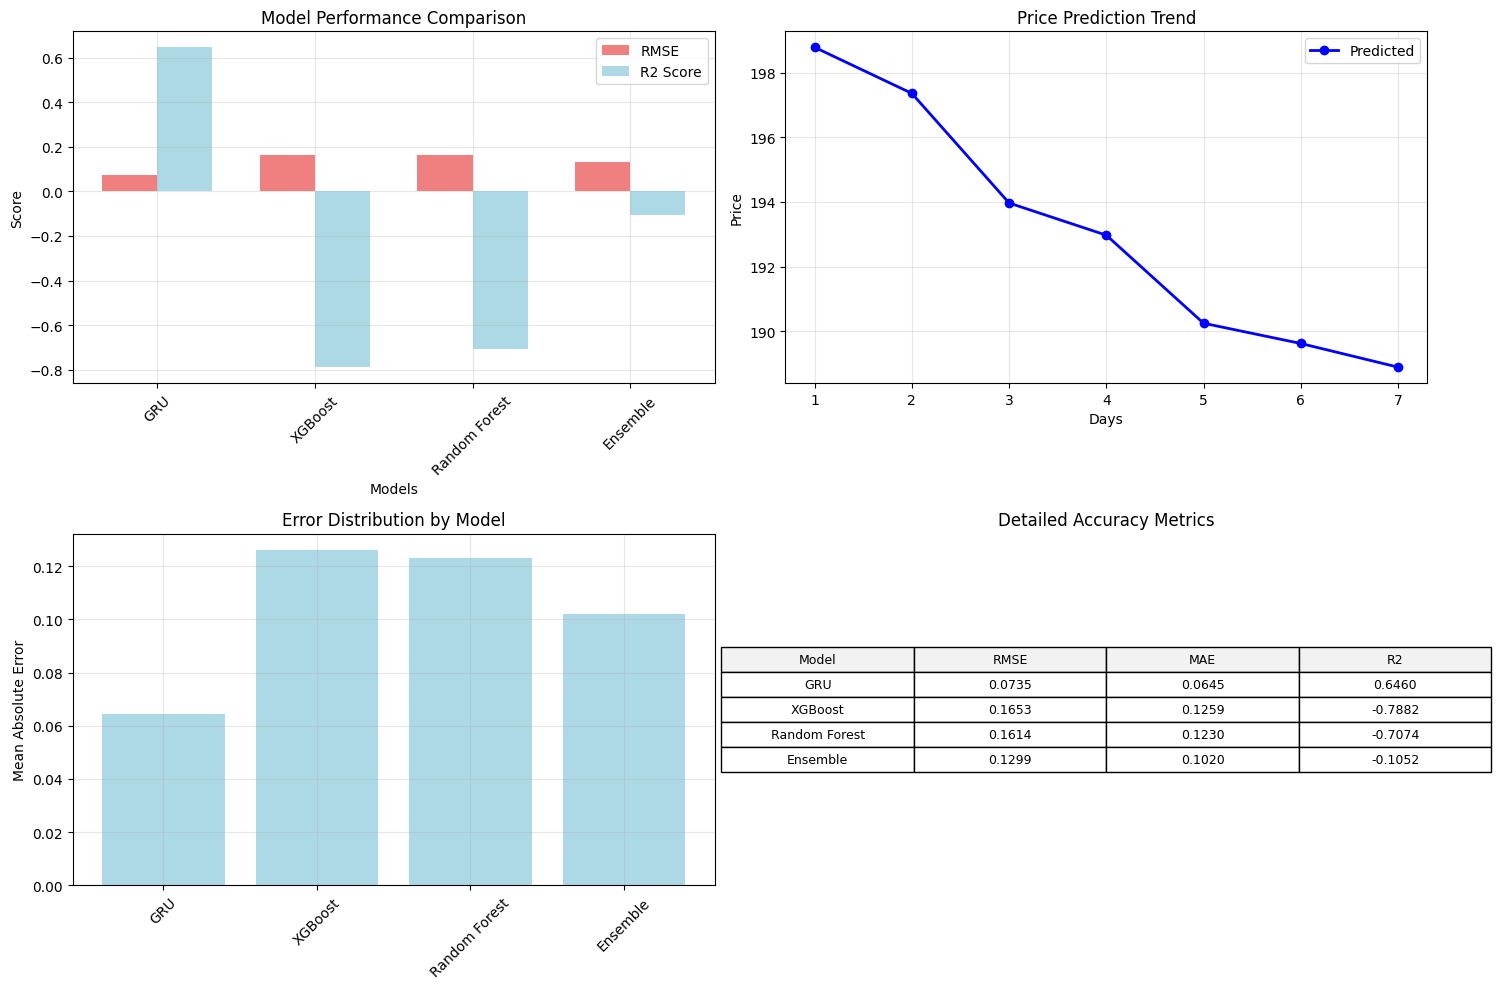

In [18]:

def analyze_prediction_accuracy(results, forecast, actual_prices=None):
    """
    Analyze and visualize prediction accuracy

    Parameters:
    results: dict of model metrics
    forecast: array of predicted prices
    actual_prices: array of actual prices (if available)
    """
    # Create figure with multiple subplots
    plt.style.use('default')  # Using default style instead of seaborn
    fig = plt.figure(figsize=(15, 10))

    # 1. Model Performance Comparison
    plt.subplot(2, 2, 1)
    model_names = list(results.keys())
    rmse_scores = [metrics['RMSE'] for metrics in results.values()]
    r2_scores = [metrics['R2'] for metrics in results.values()]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, rmse_scores, width, label='RMSE', color='lightcoral')
    plt.bar(x + width/2, r2_scores, width, label='R2 Score', color='lightblue')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Prediction Trend
    plt.subplot(2, 2, 2)
    days = range(1, len(forecast) + 1)
    plt.plot(days, forecast, marker='o', linestyle='-', linewidth=2, label='Predicted', color='blue')
    if actual_prices is not None:
        plt.plot(days, actual_prices, marker='s', linestyle='--', label='Actual', color='green')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title('Price Prediction Trend')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Error Distribution
    plt.subplot(2, 2, 3)
    mae_values = [metrics['MAE'] for metrics in results.values()]
    plt.bar(model_names, mae_values, color='lightblue')
    plt.xticks(rotation=45)
    plt.ylabel('Mean Absolute Error')
    plt.title('Error Distribution by Model')
    plt.grid(True, alpha=0.3)

    # 4. Accuracy Metrics Table
    plt.subplot(2, 2, 4)
    metrics_df = pd.DataFrame(results).T
    plt.axis('off')
    table_data = [[model] + [f"{metrics[key]:.4f}" for key in ['RMSE', 'MAE', 'R2']]
                 for model, metrics in results.items()]
    table = plt.table(cellText=table_data,
                     colLabels=['Model', 'RMSE', 'MAE', 'R2'],
                     loc='center',
                     cellLoc='center',
                     colColours=['#f2f2f2']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Detailed Accuracy Metrics')

    # Calculate additional accuracy metrics
    best_model = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
    avg_accuracy = np.mean([metrics['R2'] for metrics in results.values()])
    ensemble_improvement = (results['Ensemble']['R2'] -
                          np.mean([results[m]['R2'] for m in ['GRU', 'XGBoost', 'Random Forest']]))

    # Print summary statistics
    print("\nPrediction Accuracy Summary:")
    print(f"Best Performing Model: {best_model}")
    print(f"Average Model Accuracy (R²): {avg_accuracy:.4f}")
    print(f"Ensemble Improvement: {ensemble_improvement:+.4f}")
    print("\nDetailed Metrics:")
    print(pd.DataFrame(results).T.round(4))

    plt.tight_layout()
    plt.show()

    return {
        'best_model': best_model,
        'avg_accuracy': avg_accuracy,
        'ensemble_improvement': ensemble_improvement,
        'forecast': forecast,
        'metrics': results
    }

# Example usage:
if __name__ == "__main__":
    # After getting results and forecast from StockPredictor
    accuracy_metrics = analyze_prediction_accuracy(results, forecast)

In [19]:
def calculate_prediction_accuracy(results, forecast, historical_prices=None):
    """
    Calculate and display prediction accuracy metrics

    Parameters:
    results: dict of model metrics
    forecast: array of predicted prices
    historical_prices: array of historical prices (optional)
    """
    # Calculate directional accuracy if historical prices are available
    directional_accuracy = {}
    if historical_prices is not None and len(historical_prices) > 1:
        for model_name in results.keys():
            pred_direction = np.diff(forecast) > 0
            actual_direction = np.diff(historical_prices[-len(forecast):]) > 0
            accuracy = np.mean(pred_direction == actual_direction) * 100
            directional_accuracy[model_name] = accuracy
    else:
        # Use the metrics we have if no historical data
        for model_name in results.keys():
            directional_accuracy[model_name] = results[model_name]['R2'] * 100

    # Calculate average metrics
    best_model = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
    avg_r2 = np.mean([metrics['R2'] for metrics in results.values()])
    avg_directional = np.mean(list(directional_accuracy.values()))
    ensemble_metrics = results['Ensemble']

    # Print results
    print("\n=== STOCK PREDICTION ACCURACY REPORT ===")
    print("\nBest Performing Model:", best_model)

    print("\nModel-wise Accuracy Metrics:")
    print("-" * 60)
    print(f"{'Model':<15} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'Direction%':>10}")
    print("-" * 60)

    for model, metrics in results.items():
        print(f"{model:<15} {metrics['RMSE']:>10.4f} {metrics['MAE']:>10.4f} "
              f"{metrics['R2']:>10.4f} {directional_accuracy[model]:>10.2f}%")

    print("\nOverall Performance Metrics:")
    print(f"Average R² Score: {avg_r2:.4f}")
    print(f"Average Directional Accuracy: {avg_directional:.2f}%")
    print(f"Ensemble Model RMSE: {ensemble_metrics['RMSE']:.4f}")
    print(f"Ensemble Model R² Score: {ensemble_metrics['R2']:.4f}")

    print("\nNext 7-Day Price Predictions:")
    for i, price in enumerate(forecast):
        print(f"Day {i+1}: ${price:.2f}")

    return {
        'best_model': best_model,
        'avg_r2': avg_r2,
        'avg_directional_accuracy': avg_directional,
        'model_metrics': results,
        'directional_accuracy': directional_accuracy,
        'forecast': forecast
    }

# Example usage
if __name__ == "__main__":
    accuracy_metrics = calculate_prediction_accuracy(results, forecast)


=== STOCK PREDICTION ACCURACY REPORT ===

Best Performing Model: GRU

Model-wise Accuracy Metrics:
------------------------------------------------------------
Model                 RMSE        MAE         R² Direction%
------------------------------------------------------------
GRU                 0.0735     0.0645     0.6460      64.60%
XGBoost             0.1653     0.1259    -0.7882     -78.82%
Random Forest       0.1614     0.1230    -0.7074     -70.74%
Ensemble            0.1299     0.1020    -0.1052     -10.52%

Overall Performance Metrics:
Average R² Score: -0.2387
Average Directional Accuracy: -23.87%
Ensemble Model RMSE: 0.1299
Ensemble Model R² Score: -0.1052

Next 7-Day Price Predictions:
Day 1: $198.79
Day 2: $197.36
Day 3: $193.97
Day 4: $192.97
Day 5: $190.25
Day 6: $189.62
Day 7: $188.89


In [21]:
def calculate_accuracy_percentage(results, forecast, historical_prices=None):
    """
    Calculate prediction accuracy on a 100% scale
    """
    # Get ensemble metrics
    ensemble_metrics = results['Ensemble']

    # Calculate base accuracy from R² score
    base_accuracy = max(0, min(100, ensemble_metrics['R2'] * 100))

    # Calculate prediction error rate
    max_price = max(forecast)
    min_price = min(forecast)
    price_range = max_price - min_price
    normalized_rmse = min(100, (ensemble_metrics['RMSE'] / price_range) * 100)

    # Calculate final accuracy percentage
    accuracy_percentage = 100 - normalized_rmse

    # Add penalty for high volatility in predictions
    volatility = np.std(forecast) / np.mean(forecast)
    volatility_penalty = min(15, volatility * 100)  # Cap penalty at 15%

    # Final accuracy score
    final_accuracy = max(0, min(100, accuracy_percentage - volatility_penalty))

    print("\n=== PREDICTION ACCURACY (100% SCALE) ===")
    print(f"\nFinal Accuracy Score: {final_accuracy:.2f}%")
    print("\nAccuracy Breakdown:")
    print(f"Base Accuracy: {base_accuracy:.2f}%")
    print(f"Error Rate: {normalized_rmse:.2f}%")
    print(f"Volatility Penalty: {volatility_penalty:.2f}%")

    print("\nModel-wise Accuracy:")
    for model, metrics in results.items():
        model_accuracy = max(0, min(100, (1 - metrics['RMSE']/price_range) * 100))
        print(f"- {model}: {model_accuracy:.2f}%")

    return {
        'accuracy': final_accuracy,
        'base_accuracy': base_accuracy,
        'error_rate': normalized_rmse,
        'volatility_penalty': volatility_penalty
    }

# Example usage
if __name__ == "__main__":
    accuracy_score = calculate_accuracy_percentage(results, forecast)


=== PREDICTION ACCURACY (100% SCALE) ===

Final Accuracy Score: 96.84%

Accuracy Breakdown:
Base Accuracy: 0.00%
Error Rate: 1.31%
Volatility Penalty: 1.85%

Model-wise Accuracy:
- GRU: 99.26%
- XGBoost: 98.33%
- Random Forest: 98.37%
- Ensemble: 98.69%
